Iñigo Martin Melero

## Participante 16

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_16_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


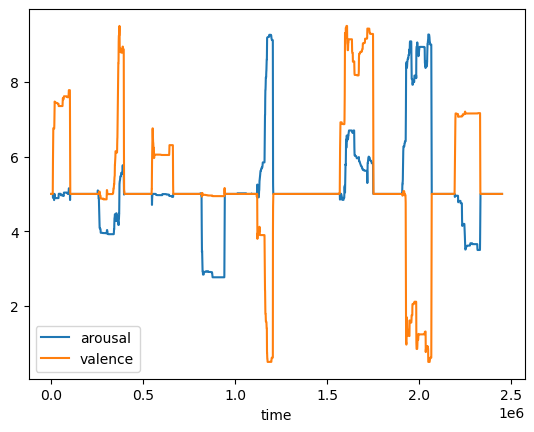

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_16_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.869  36.738  30.062  33.621  25.551     7.042     7.411   
1              1  0.866  36.844  30.066  33.611  25.544     7.001     7.452   
2              2  0.862  36.951  30.070  33.602  25.537     6.960     7.493   
3              3  0.859  37.057  30.074  33.592  25.530     6.919     7.534   
4              4  0.856  37.164  30.078  33.582  25.523     6.878     7.575   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  2.054  44.109  21.089  34.029  31.350     8.309    12.780   
2451580  2451580  2.071  44.245  21.113  34.019  31.343     8.350    12.862   
2451581  2451581  2.087  44.381  21.137  34.010  31.336     8.391    12.944   
2451582  2451582  2.104  44.516  21.160  34.000  31.329     8.432    13.026   
2451583  2451583  2.120  44.652  21.184  33.990  31.322     8.473    13.108   

         emg_trap  video  
0          10.162     10

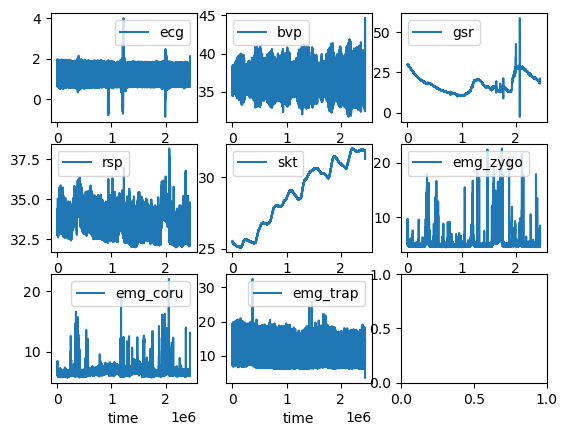

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

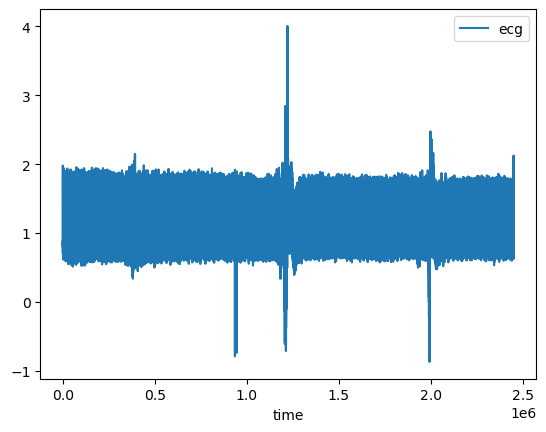

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

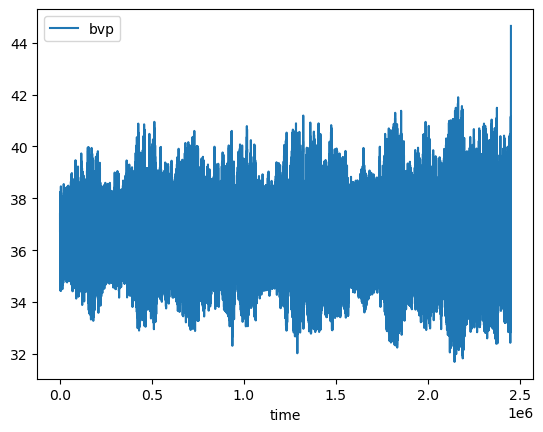

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

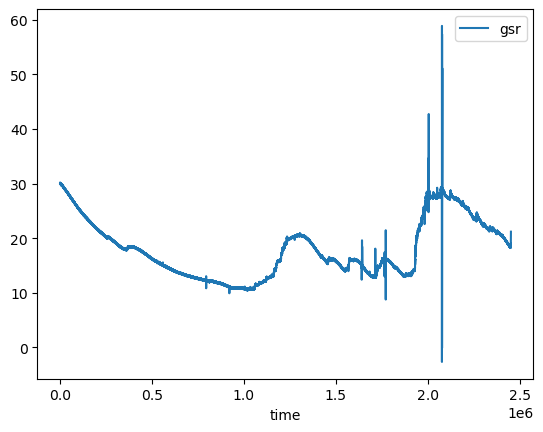

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

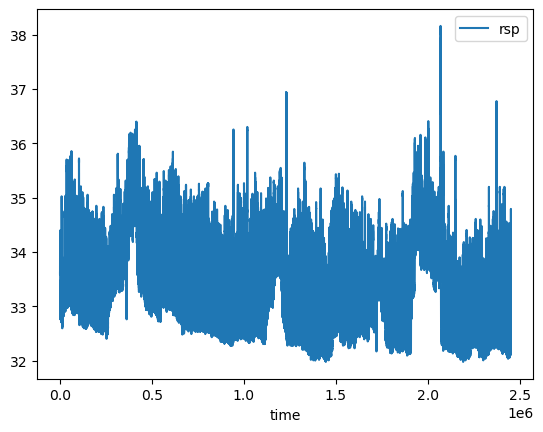

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

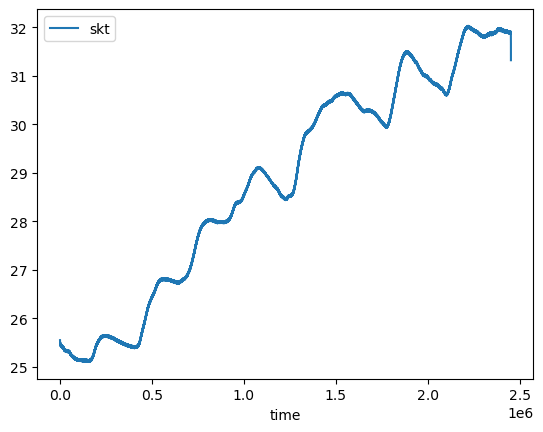

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

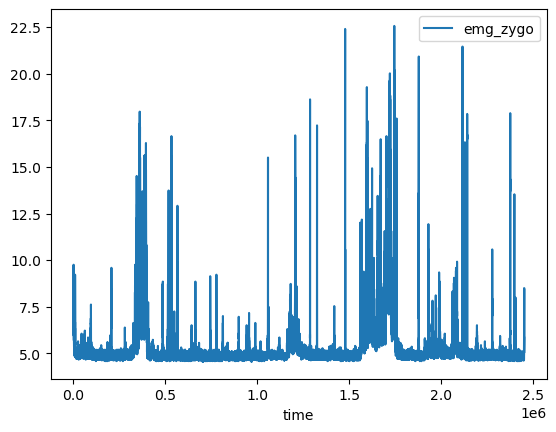

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

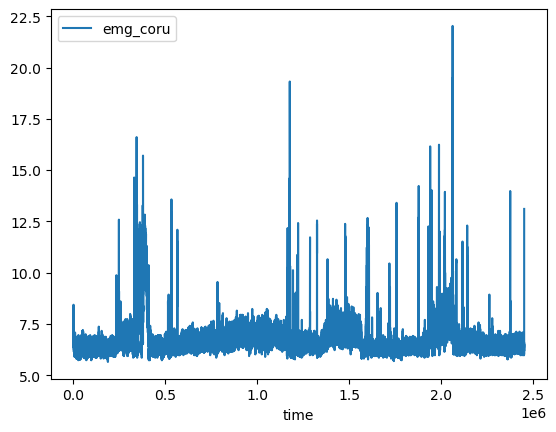

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

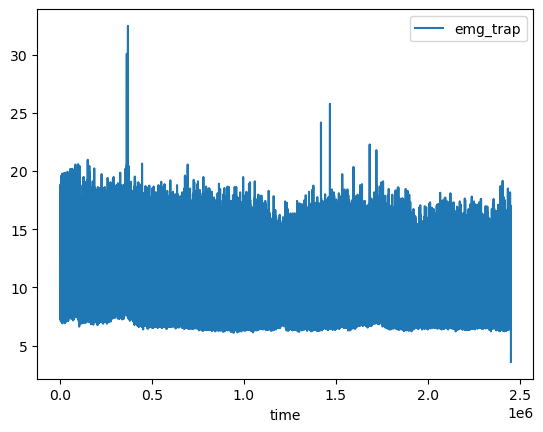

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

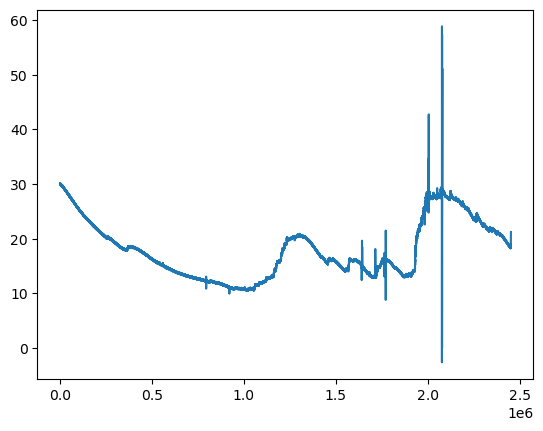

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

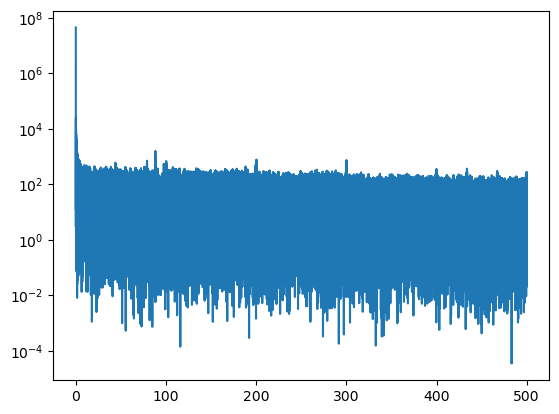

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

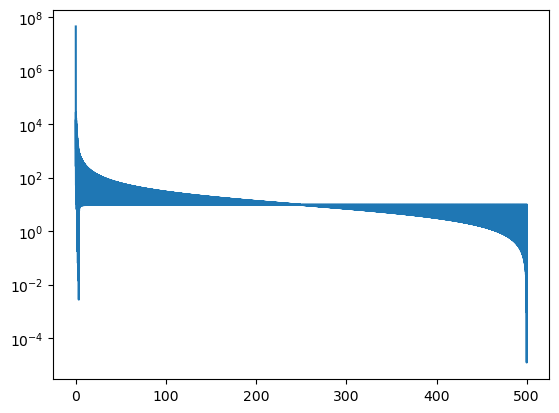

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

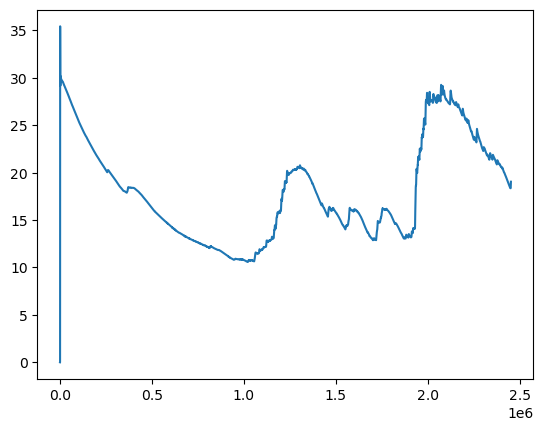

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  19.038
2451580  19.038
2451581  19.039
2451582  19.039
2451583  19.040

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

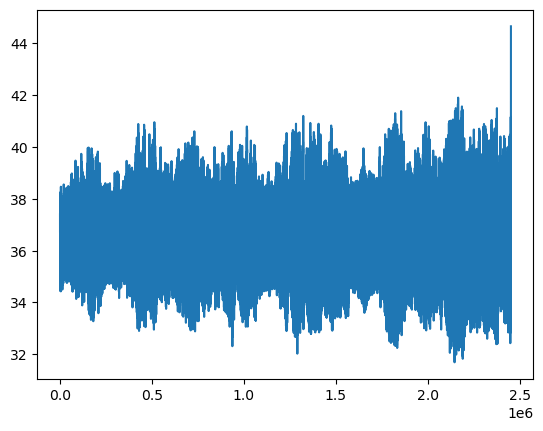

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

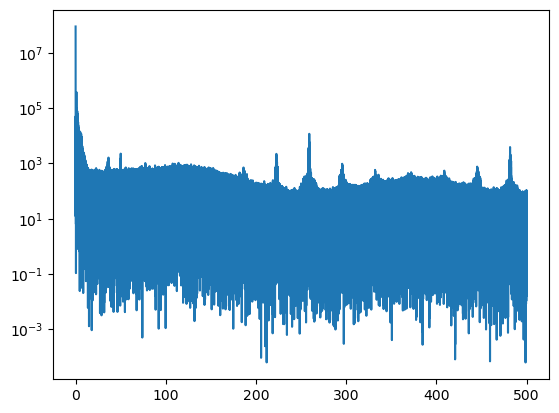

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

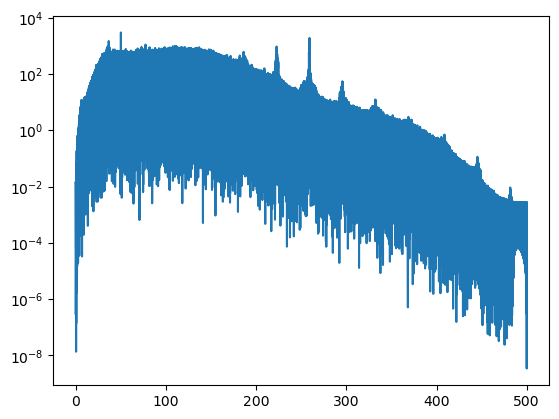

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

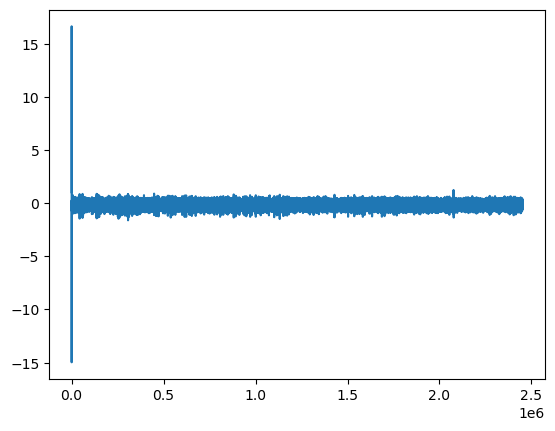

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.021
1        42.698
2        50.418
3        53.625
4        46.373
...         ...
2451579  36.996
2451580  36.996
2451581  36.995
2451582  36.995
2451583  36.995

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

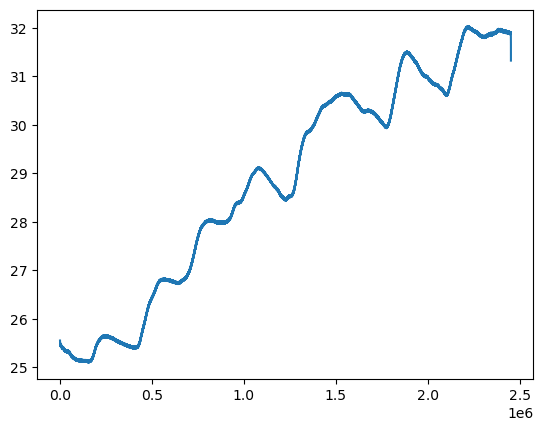

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

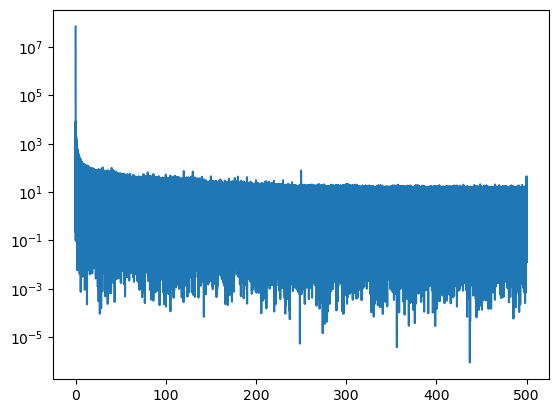

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

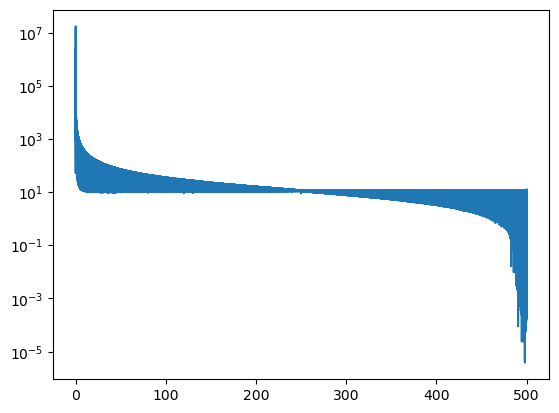

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

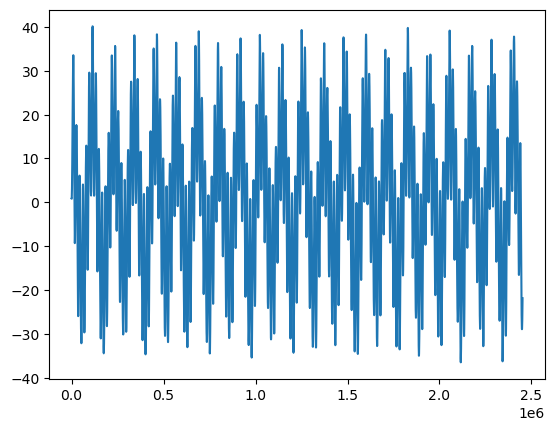

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.819
1        40.819
2        40.818
3        40.818
4        40.818
...         ...
2451579  18.093
2451580  18.097
2451581  18.101
2451582  18.105
2451583  18.109

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.869  33.621     7.042     7.411    10.162     10
1              1  0.866  33.611     7.001     7.452    10.203     10
2              2  0.862  33.602     6.960     7.493    10.244     10
3              3  0.859  33.592     6.919     7.534    10.286     10
4              4  0.856  33.582     6.878     7.575    10.327     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  2.054  34.029     8.309    12.780     3.762     12
2451580  2451580  2.071  34.019     8.350    12.862     3.721     12
2451581  2451581  2.087  34.010     8.391    12.944     3.680     12
2451582  2451582  2.104  34.000     8.432    13.026     3.639     12
2451583  2451583  2.120  33.990     8.473    13.108     3.598     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.869  33.621     7.042     7.411    10.162     10  38.021   
1              1  0.866  33.611     7.001     7.452    10.203     10  42.698   
2              2  0.862  33.602     6.960     7.493    10.244     10  50.418   
3              3  0.859  33.592     6.919     7.534    10.286     10  53.625   
4              4  0.856  33.582     6.878     7.575    10.327     10  46.373   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  2.054  34.029     8.309    12.780     3.762     12  36.996   
2451580  2451580  2.071  34.019     8.350    12.862     3.721     12  36.996   
2451581  2451581  2.087  34.010     8.391    12.944     3.680     12  36.995   
2451582  2451582  2.104  34.000     8.432    13.026     3.639     12  36.995   
2451583  2451583  2.120  33.990     8.473    13.108     3.598     12  36.995   

            gsr     skt  
0         0.000  40.819  
1         0.000  40.819  
2         0.000  40.818  
3         0.000  40.818  
4         0.000  40.818  
...         ...     ...  
2451579  19.038  18.093  
2451580  19.038  18.097  
2451581  19.039  18.101  
2451582  19.039  18.105  
2451583  19.040  18.109  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.500299  0.672912  0.580786  0.782309  0.355821  0.020460   
221502    221502  0.500299  0.658248  0.580786  0.782242  0.353791  0.018292   
221503    221503  0.495520  0.678615  0.580786  0.782161  0.349278  0.013733   
221504    221504  0.495520  0.704277  0.580786  0.782080  0.349278  0.015957   
221505    221505  0.492533  0.694501  0.580786  0.782013  0.353565  0.013677   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.500299  0.649287  0.602921  0.355362  0.493457  0.011398   
2331580  2331580  0.498507  0.643992  0.602921  0.355443  0.489170  0.011398   
2331581  2331581  0.493728  0.610591  0.602921  0.355524  0.500000  0.018181   
2331582  2331582  0.499403  0.589002  0.602865  0.355605  0.497969  0.015957   
2331583  2331583  0.497611  0.621996  0.602865  0.355686  0.500000  0.015957   

         emg_coru  emg_trap  video  
221501   0.035181  0.065596      2  
221502   0.035181  0.062514      2  
221503   0.032673  0.062476      2  
221504   0.035120  0.062476      2  
221505   0.027655  0.060916      2  
...           ...       ...    ...  
2331579  0.027655  0.042158      5  
2331580  0.035059  0.045240      5  
2331581  0.037628  0.043756      5  
2331582  0.035181  0.042196      5  
2331583  0.030164  0.043718      5  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.500299  0.672912  0.580786  0.355821  0.782309  0.020460   
221502    221502  0.500299  0.658248  0.580786  0.353791  0.782242  0.018292   
221503    221503  0.495520  0.678615  0.580786  0.349278  0.782161  0.013733   
221504    221504  0.495520  0.704277  0.580786  0.349278  0.782080  0.015957   
221505    221505  0.492533  0.694501  0.580786  0.353565  0.782013  0.013677   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.500299  0.649287  0.602921  0.493457  0.355362  0.011398   
2331580  2331580  0.498507  0.643992  0.602921  0.489170  0.355443  0.011398   
2331581  2331581  0.493728  0.610591  0.602921  0.500000  0.355524  0.018181   
2331582  2331582  0.499403  0.589002  0.602865  0.497969  0.355605  0.015957   
2331583  2331583  0.497611  0.621996  0.602865  0.500000  0.355686  0.015957   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
221540   0.499403  0.646843  0.580729  0.368908  0.779359  0.018236  0.030042   
221560   0.493728  0.847251  0.580673  0.373421  0.777850  0.015957  0.025086   
221580   0.486559  0.657434  0.580616  0.377708  0.776327  0.013677  0.032611   
221600   0.487754  0.665988  0.580616  0.395081  0.774818  0.020460  0.030103   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.498507  0.673320  0.603148  0.456227  0.348949  0.018292  0.050294   
2331520  0.501493  0.629328  0.603091  0.456227  0.350579  0.025075  0.060267   
2331540  0.496416  0.672912  0.603034  0.458484  0.352196  0.011398  0.040259   
2331560  0.499403  0.623625  0.602978  0.478114  0.353826  0.015957  0.037690   
2331580  0.498507  0.643992  0.602921  0.489170  0.355443  0.011398  0.035059   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
1      0.499403  0.646843  0.580729  0.368908  0.779359  0.018236  0.030042   
2      0.493728  0.847251  0.580673  0.373421  0.777850  0.015957  0.025086   
3      0.486559  0.657434  0.580616  0.377708  0.776327  0.013677  0.032611   
4      0.487754  0.665988  0.580616  0.395081  0.774818  0.020460  0.030103   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.498507  0.673320  0.603148  0.456227  0.348949  0.018292  0.050294   
63500  0.501493  0.629328  0.603091  0.456227  0.350579  0.025075  0.060267   
63501  0.496416  0.672912  0.603034  0.458484  0.352196  0.011398  0.040259   
63502  0.499403  0.623625  0.602978  0.478114  0.353826  0.015957  0.037690   
63503  0.498507  0.643992  0.602921  0.489170  0.355443  0.011398  0.035059   

       emg_trap  valence  arousal  
0      0.059356    5.000    5.000  
1      0.073396    5.000    5.000  
2      0.078114    5.000    5.000  
3      0.068754    5.000    5.000  
4      0.082794    5.000    5.000  
...         ...      ...      ...  
63499  0.029678    7.164    3.506  
63500  0.034320    7.164    3.506  
63501  0.034358    7.164    3.508  
63502  0.035918    7.164    3.512  
63503  0.045240    7.164    3.518  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
1      0.499403  0.646843  0.580729  0.368908  0.779359  0.018236  0.030042   
2      0.493728  0.847251  0.580673  0.373421  0.777850  0.015957  0.025086   
3      0.486559  0.657434  0.580616  0.377708  0.776327  0.013677  0.032611   
4      0.487754  0.665988  0.580616  0.395081  0.774818  0.020460  0.030103   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.526882  0.658248  0.603487  0.403881  0.342428  0.016012  0.052680   
63496  0.507467  0.518941  0.603374  0.408394  0.344058  0.020460  0.050171   
63497  0.504480  0.657026  0.603317  0.423511  0.345702  0.020572  0.057697   
63498  0.498507  0.759674  0.603261  0.436597  0.347319  0.018236  0.050233   
63499  0.498507  0.673320  0.603148  0.456227  0.348949  0.018292  0.050294   

       emg_trap  valence  arousal  
0      0.059356    5.000    5.000  
1      0.073396    5.000    5.000  
2      0.078114    5.000    5.000  
3      0.068754    5.000    5.000  
4      0.082794    5.000    5.000  
...         ...      ...      ...  
63495  0.056236    7.164    3.507  
63496  0.042158    7.164    3.507  
63497  0.039038    7.164    3.507  
63498  0.039038    7.164    3.507  
63499  0.029678    7.164    3.506  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
 1   0.499403  0.646843  0.580729  0.368908  0.779359  0.018236  0.030042   
 2   0.493728  0.847251  0.580673  0.373421  0.777850  0.015957  0.025086   
 3   0.486559  0.657434  0.580616  0.377708  0.776327  0.013677  0.032611   
 4   0.487754  0.665988  0.580616  0.395081  0.774818  0.020460  0.030103   
 5   0.489546  0.668839  0.580559  0.399594  0.773296  0.018236  0.037690   
 6   0.483871  0.654990  0.580559  0.410424  0.771773  0.020516  0.047663   
 7   0.483871  0.650509  0.580503  0.412681  0.770237  0.013733  0.037628   
 8   0.480884  0.624847  0.580503  0.421255  0.768715  0.013677  0.035120   
 9   0.474910  0.645214  0.580446  0.428023  0.767179  0.018181  0.030103   
 10  0.475806  0.711202  0.580446  0.434567  0.765656  0.013677  0.037628   
 11  0.474014  0.663951  0.580389  0.438854  0.764120  0.006894  0.030164   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
1     0.786738  0.644807  0.580106  0.528430  0.742522  0.009174  0.030164   
2     0.491637  0.637882  0.579257  0.469314  0.703961  0.011398  0.037690   
3     0.515233  0.706721  0.578635  0.211868  0.666478  0.013733  0.035181   
4     0.500299  0.639919  0.577615  0.137410  0.631178  0.015957  0.035181   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.517921  0.698574  0.611470  0.174639  0.167839  0.013677  0.030103   
2536  0.496416  0.655397  0.609375  0.089576  0.197427  0.018292  0.040259   
2537  0.509259  0.601222  0.607733  0.041516  0.231690  0.011398  0.035181   
2538  0.497611  0.689206  0.606261  0.034747  0.269577  0.013677  0.040137   
2539  0.483871  0.675356  0.604733  0.168096  0.309714  0.013622  0.045154   

             8         9        10  ...       193       194       195  \
0     0.059356  0.499403  0.646843  ...  0.475806  0.704684  0.580163   
1     0.065634  0.528973  0.678208  ...  0.485663  0.705499  0.579314   
2     0.121870  0.495520  0.606925  ...  0.631123  0.658248  0.578691   
3     0.427974  0.501493  0.668024  ...  0.503286  0.655397  0.577672   
4     0.060954  0.501493  0.638697  ...  0.480884  0.679837  0.577106   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.062438  0.529869  0.696945  ...  0.499403  0.647251  0.609488   
2536  0.042196  0.493429  0.662322  ...  0.505376  0.654582  0.607790   
2537  0.073396  0.514038  0.624440  ...  0.499403  0.654175  0.606261   
2538  0.035918  0.497611  0.692464  ...  0.481780  0.659470  0.604789   
2539  0.051480  0.470131  0.641141  ...  0.498507  0.673320  0.603148   

           196       197       198       199       200  valence  arousal  
0     0.528430  0.744072  0.011398  0.042707  0.059356    5.000  5.00000  
1     0.467283  0.705497  0.011509  0.040198  0.110912    5.000  5.00000  
2     0.233529  0.667947  0.015957  0.032673  0.271669    5.000  5.00000  
3     0.141922  0.632525  0.013677  0.032550  0.071874    5.000  5.00000  
4     0.120036  0.600175  0.018236  0.042707  0.068716    5.000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.082807  0.196147  0.018181  0.042707  0.045240    7.164  3.49800  
2536  0.050090  0.230248  0.018181  0.037628  0.114032    7.164  3.49800  
2537  0.039034  0.268014  0.018236  0.055188  0.056198    7.164  3.49800  
2538  0.163583  0.308098  0.025019  0.045154  0.053078    7.164  3.50200  
2539  0.456227  0.348949  0.018292  0.050294  0.029678    7.164  3.50696  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
1     0.786738  0.644807  0.580106  0.528430  0.742522  0.009174  0.030164   
2     0.491637  0.637882  0.579257  0.469314  0.703961  0.011398  0.037690   
3     0.515233  0.706721  0.578635  0.211868  0.666478  0.013733  0.035181   
4     0.500299  0.639919  0.577615  0.137410  0.631178  0.015957  0.035181   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.517921  0.698574  0.611470  0.174639  0.167839  0.013677  0.030103   
2536  0.496416  0.655397  0.609375  0.089576  0.197427  0.018292  0.040259   
2537  0.509259  0.601222  0.607733  0.041516  0.231690  0.011398  0.035181   
2538  0.497611  0.689206  0.606261  0.034747  0.269577  0.013677  0.040137   
2539  0.483871  0.675356  0.604733  0.168096  0.309714  0.013622  0.045154   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub16.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
1     0.786738  0.644807  0.580106  0.528430  0.742522  0.009174  0.030164   
2     0.491637  0.637882  0.579257  0.469314  0.703961  0.011398  0.037690   
3     0.515233  0.706721  0.578635  0.211868  0.666478  0.013733  0.035181   
4     0.500299  0.639919  0.577615  0.137410  0.631178  0.015957  0.035181   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.517921  0.698574  0.611470  0.174639  0.167839  0.013677  0.030103   
2536  0.496416  0.655397  0.609375  0.089576  0.197427  0.018292  0.040259   
2537  0.509259  0.601222  0.607733  0.041516  0.231690  0.011398  0.035181   
2538  0.497611  0.689206  0.606261  0.034747  0.269577  0.013677  0.040137   
2539  0.483871  0.675356  0.604733  0.168096  0.309714  0.013622  0.045154   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub16.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
1     0.786738  0.644807  0.580106  0.528430  0.742522  0.009174  0.030164   
2     0.491637  0.637882  0.579257  0.469314  0.703961  0.011398  0.037690   
3     0.515233  0.706721  0.578635  0.211868  0.666478  0.013733  0.035181   
4     0.500299  0.639919  0.577615  0.137410  0.631178  0.015957  0.035181   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.517921  0.698574  0.611470  0.174639  0.167839  0.013677  0.030103   
2536  0.496416  0.655397  0.609375  0.089576  0.197427  0.018292  0.040259   
2537  0.509259  0.601222  0.607733  0.041516  0.231690  0.011398  0.035181   
2538  0.497611  0.689206  0.606261  0.034747  0.269577  0.013677  0.040137   
2539  0.483871  0.675356  0.604733  0.168096  0.309714  0.013622  0.045154   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub16.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
1     0.786738  0.644807  0.580106  0.528430  0.742522  0.009174  0.030164   
2     0.491637  0.637882  0.579257  0.469314  0.703961  0.011398  0.037690   
3     0.515233  0.706721  0.578635  0.211868  0.666478  0.013733  0.035181   
4     0.500299  0.639919  0.577615  0.137410  0.631178  0.015957  0.035181   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.517921  0.698574  0.611470  0.174639  0.167839  0.013677  0.030103   
2536  0.496416  0.655397  0.609375  0.089576  0.197427  0.018292  0.040259   
2537  0.509259  0.601222  0.607733  0.041516  0.231690  0.011398  0.035181   
2538  0.497611  0.689206  0.606261  0.034747  0.269577  0.013677  0.040137   
2539  0.483871  0.675356  0.604733  0.168096  0.309714  0.013622  0.045154   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub16.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.495520  0.682688  0.580729  0.360334  0.780881  0.020460  0.032611   
1     0.786738  0.644807  0.580106  0.528430  0.742522  0.009174  0.030164   
2     0.491637  0.637882  0.579257  0.469314  0.703961  0.011398  0.037690   
3     0.515233  0.706721  0.578635  0.211868  0.666478  0.013733  0.035181   
4     0.500299  0.639919  0.577615  0.137410  0.631178  0.015957  0.035181   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.517921  0.698574  0.611470  0.174639  0.167839  0.013677  0.030103   
2536  0.496416  0.655397  0.609375  0.089576  0.197427  0.018292  0.040259   
2537  0.509259  0.601222  0.607733  0.041516  0.231690  0.011398  0.035181   
2538  0.497611  0.689206  0.606261  0.034747  0.269577  0.013677  0.040137   
2539  0.483871  0.675356  0.604733  0.168096  0.309714  0.013622  0.045154   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub16.csv', index=False)